In [27]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from PIL import ImageDraw
from scipy.spatial.distance import cosine

# Load MTCNN for face detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(keep_all=False, device=device)  # keep_all=False ensures single face is returned
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

In [28]:
def get_face_embedding(image):
    """Detects a face from an image and returns its embedding"""
    img_cropped = mtcnn(image)  # Detect faces and return cropped tensor

    if img_cropped is None:
        print("No face detected!")
        return None

    if img_cropped.ndim == 3:  # If it's a single face, add batch dimension
        img_cropped = img_cropped.unsqueeze(0)

    img_cropped = img_cropped.to(device)  # Move to device (CPU/GPU)
    img_embedding = facenet(img_cropped).detach().cpu().numpy()  # Convert to NumPy
    return img_embedding

In [29]:
# Load your reference image (a pre-given image of your face)
reference_img = Image.open("./face-resources/me1.jpg")  # Replace with your image path
reference_embedding = get_face_embedding(reference_img)

if reference_embedding is None:
    print("No face detected in the reference image!")
else:
    print("Reference face embedding extracted successfully!")

Reference face embedding extracted successfully!


In [30]:
def recognize_person(image, reference_embedding, threshold=0.5):
    """
    Detect faces in an image, compute their embeddings, and check if they match the reference embedding.
    """
    faces = mtcnn(image)  # Detect faces (returns cropped face tensors)

    if faces is None:
        print("No faces detected in the image.")
        return []

    detected_faces = []
    
    # Ensure output is always a list (even if there's only one face)
    if not isinstance(faces, list):
        faces = [faces]

    for face in faces:
        # Add batch dimension if necessary
        if face.ndim == 3:
            face = face.unsqueeze(0)

        face = face.to(device)  # Move to GPU/CPU
        face_embedding = facenet(face).detach().cpu().numpy()  # Extract embedding
        
        # Flatten both reference and detected embeddings to 1D
        face_embedding = face_embedding.flatten()
        reference_embedding = reference_embedding.flatten()

        # Compute similarity
        similarity = 1 - cosine(face_embedding, reference_embedding)

        if similarity > threshold:  # Check if similarity is above threshold
            detected_faces.append(face_embedding)

    return detected_faces

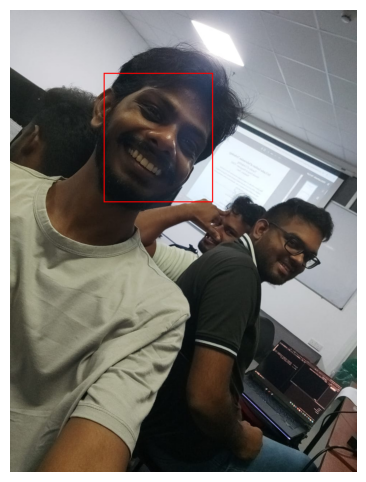

1 faces match the reference person!


In [41]:
def recognize_and_highlight(image_path, reference_embedding, threshold=0.5):
    """
    Detect faces in an image, compute their embeddings, and highlight the recognized face.
    """
    # Load image
    image = Image.open(image_path)
    
    # Detect faces and bounding boxes
    boxes, _ = mtcnn.detect(image)

    if boxes is None:
        print("No faces detected in the image.")
        return
    
    # Convert image to draw on it
    draw = ImageDraw.Draw(image)

    # Detect and recognize faces
    faces = mtcnn(image)  # Cropped faces

    if faces is None:
        print("No faces detected.")
        return

    if not isinstance(faces, list):
        faces = [faces]  # Ensure it's a list

    detected_faces = 0

    for i, face in enumerate(faces):
        if face.ndim == 3:
            face = face.unsqueeze(0)

        face = face.to(device)
        face_embedding = facenet(face).detach().cpu().numpy().flatten()
        ref_embedding = reference_embedding.flatten()

        # Compute similarity
        similarity = 1 - cosine(face_embedding, ref_embedding)

        if similarity > threshold:  # Check if similarity is above threshold
            detected_faces += 1

            # Draw bounding box around the detected face
            x1, y1, x2, y2 = boxes[i]
            draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    print(f"{detected_faces} faces match the reference person!")

# Run the function on the group image
recognize_and_highlight("./face-resources/gr7.jpg", reference_embedding)